<a href="https://colab.research.google.com/github/pratik443/QC-backtraders-backtesting/blob/main/Copy_of_QC_backtraders_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install backtrader
!pip install yfinance

In [3]:
import backtrader as bt
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
import backtrader.feeds as feeds

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
%cd '/content/drive/MyDrive/QC_backtraders'

/content/drive/MyDrive/QC_backtraders


Starting Portfolio Value: 10000.00
Starting Portfolio Cash: 10000.00
[*********************100%***********************]  1 of 1 completed
2015-11-06, BUY EXECUTED, Price: 30.28, Cost: 30.28, Comm 0.03
2015-11-09, BUY EXECUTED, Price: 30.24, Cost: 30.24, Comm 0.03
2015-11-10, BUY EXECUTED, Price: 29.23, Cost: 29.23, Comm 0.03
2015-12-22, SELL EXECUTED, Price: 26.85, Cost: 29.91, Comm 0.03
2015-12-23, SELL EXECUTED, Price: 26.82, Cost: 29.91, Comm 0.03
2015-12-24, SELL EXECUTED, Price: 27.25, Cost: 29.91, Comm 0.03
2015-12-24, OPERATION PROFIT, GROSS -8.83, NET -9.00
2016-03-18, BUY EXECUTED, Price: 26.58, Cost: 26.58, Comm 0.03
2016-03-21, BUY EXECUTED, Price: 26.48, Cost: 26.48, Comm 0.03
2016-03-22, BUY EXECUTED, Price: 26.31, Cost: 26.31, Comm 0.03
2016-03-23, BUY EXECUTED, Price: 26.62, Cost: 26.62, Comm 0.03
2016-03-24, BUY EXECUTED, Price: 26.37, Cost: 26.37, Comm 0.03
2016-03-28, BUY EXECUTED, Price: 26.50, Cost: 26.50, Comm 0.03
2016-03-29, BUY EXECUTED, Price: 26.22, Cost: 26.2

<IPython.core.display.Javascript object>

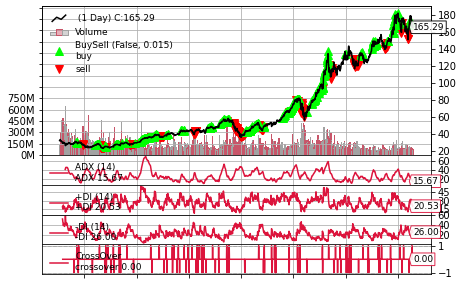

In [7]:
# Average Directional Movement Index
ADX = 25
QTY = 1


class ADXDMICross(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        self.adx = bt.ind.ADX()
        self.dmiplus, self.dmimin = bt.ind.PlusDI(), bt.ind.MinusDI()
        self.crossoverdmi = bt.ind.CrossOver(self.dmimin, self.dmiplus)

    def next(self):
        if self.dmiplus > self.dmimin and self.adx[0] > ADX:
            self.buy(size=QTY)

        if self.dmiplus < self.dmimin and self.adx[0] > ADX:
            self.close(size=QTY)

        if self.datas[0].datetime.date(0) == datetime(2020, 1, 23).date():
            self.close()

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))


cerebro = bt.Cerebro(stdstats=False)
cerebro.addobserver(bt.observers.BuySell)

print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
print('Starting Portfolio Cash: %.2f' % cerebro.broker.get_cash())
cerebro.addstrategy(ADXDMICross)
cerebro.broker.setcommission(commission=0.001)
data0 = data = bt.feeds.PandasData(dataname=yf.download('AAPL', '2015-07-15', '2022-04-15'))
cerebro.adddata(data0)
cerebro.broker.set_cash(100000.0)
cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
print('Final Portfolio Cash: %.2f' % cerebro.broker.get_cash())
figure = plt.gcf()
figure.set_size_inches(10,5)
cerebro.plot()[0][0].savefig('figure_ADXDMICross.png', dpi=300)

In [8]:
class RSMA(bt.Strategy):
    params = (
              ('maperiod' , 15),
            )
  
    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
      self.dataclose = self.datas[0].close
      self.order = None
      self.rsi = bt.indicators.RSI(self.datas[0])
      ma_fast = bt.ind.SMA(period=25)
      ma_slow = bt.ind.SMA(period=50)
      self.crossover = bt.ind.CrossOver(ma_fast, ma_slow)


    def notify_order(self, order):
      if order.status in [order.Submitted, order.Accepted]:
        return
        
      if order.status in [order.Completed]:
        if order.isbuy():
          self.log('BUY EXECUTED :Price- %.2f, Cost- %2.f, Commission- %2f' % (order.executed.price, order.executed.value, order.executed.comm))
        elif order.issell():
          self.log('SELL EXECUTED :Price- %.2f, Cost- %.2f, Commission- %2f' % (order.executed.price, order.executed.value, order.executed.comm))
        self.bar_executed = len(self)

      elif order.status in [order.Canceled, order.Margin, order.Rejected]:
        self.log('ORDER CANCELLED/ MARGIN/ REJECTED')
      self.order = None


    def notify_trade(self, trade):
      if not trade.isclosed:
        return

      self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
            (trade.pnl, trade.pnlcomm))
        

    def next(self):
      if self.order:
        return

      elif not self.position:
        # print(self.rsi)
        if self.crossover > 0 and self.rsi > 50: 
          self.log('BUY CREATE - %.2f' % self.dataclose[0])
          self.order = self.buy()

        

      else:
        # print(self.rsi)
        if self.crossover < 0 and self.rsi < 50:
          self.log('SELL CREATE - %.2f' % self.dataclose[0])
          self.order = self.sell()

In [9]:
multi_cerebro = bt.Cerebro()
multi_cerebro.broker.setcash(1000000.0)
multi_cerebro.adddata(data)
multi_cerebro.addstrategy(RSMA)
multi_cerebro.broker.setcommission(commission=0.001)

starting portfolio: 1000000.00
2015-10-23, BUY CREATE - 29.77
2015-10-26, BUY EXECUTED :Price- 29.52, Cost- 30, Commission- 0.029520
2015-12-17, SELL CREATE - 27.25
2015-12-18, SELL EXECUTED :Price- 27.23, Cost- 29.52, Commission- 0.027228
2015-12-18, OPERATION PROFIT, GROSS -2.29, NET -2.35
2016-03-15, BUY CREATE - 26.15
2016-03-16, BUY EXECUTED :Price- 26.15, Cost- 26, Commission- 0.026153
2016-05-09, SELL CREATE - 23.20
2016-05-10, SELL EXECUTED :Price- 23.33, Cost- 26.15, Commission- 0.023333
2016-05-10, OPERATION PROFIT, GROSS -2.82, NET -2.87
2016-08-01, BUY CREATE - 26.51
2016-08-02, BUY EXECUTED :Price- 26.51, Cost- 27, Commission- 0.026513
2016-11-17, SELL CREATE - 27.49
2016-11-18, SELL EXECUTED :Price- 27.43, Cost- 26.51, Commission- 0.027430
2016-11-18, OPERATION PROFIT, GROSS 0.92, NET 0.86
2016-12-23, BUY CREATE - 29.13
2016-12-27, BUY EXECUTED :Price- 29.13, Cost- 29, Commission- 0.029130
2017-06-29, SELL CREATE - 35.92
2017-06-30, SELL EXECUTED :Price- 36.11, Cost- 29.1

<IPython.core.display.Javascript object>

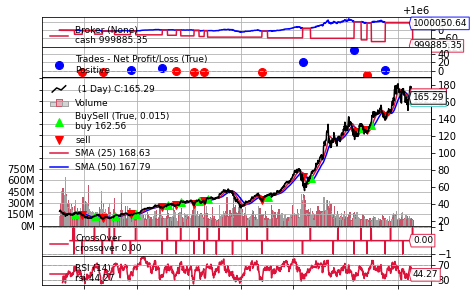

In [10]:
print('starting portfolio: %.2f' % multi_cerebro.broker.getvalue())
multi_cerebro.run()
print('final portfolio: %.2f' % multi_cerebro.broker.getvalue())
multi_cerebro.plot()[0][0].savefig('figure_Multistrat.png', dpi=300)